# Transformer

In [ ]:
import copy
from typing import Optional, Any, Union, Callable

import torch
from torch import Tensor
from torch.nn import functional as F, Module, MultiheadAttention, ModuleList, Dropout, Linear, LayerNorm
from torch.nn.init import xavier_uniform_

## Context Encoding

In [ ]:
class PositionWiseFeedForward(Module):
    def __init__(self, d_model, d_ff, dropout):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.dropout(self.relu(self.fc1(x))))

In [ ]:
class ContextEncoderLayer(Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(ContextEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, ctx_key_pending_mask: Optional[Tensor] = None) -> Tensor:
        attn_output = self.self_attn(x, x, x, key_padding_mask=ctx_key_pending_mask, need_weights=False)[0]
        x = self.norm1(x + self.dropout1(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x

In [ ]:
class ContextGating(Module):
    def __init__(self, d_model, d_cg):
        super(ContextGating, self).__init__()
        self.gating1 = nn.Linear(d_model, d_cg, bias=False)
        self.gating2 = nn.Linear(d_model, d_cg, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, ctx_attn_input, ctx_attn_output):
        gate = self.sigmoid(self.gating1(ctx_attn_input) + self.gating2(ctx_attn_output))
        return gate * ctx_attn_input + (1 - gate) * ctx_attn_output

## Utils

In [ ]:
def _get_clones(module, N):
    return ModuleList([copy.deepcopy(module) for i in range(N)])


def _get_activation_fn(activation: str) -> Callable[[Tensor], Tensor]:
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))

## Encoder

In [ ]:
class TransformerEncoderLayer(Module):
    __constants__ = ['batch_first', 'norm_first']

    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dim_contextgating: int = 512, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                            **factory_kwargs)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)
        self.dropout3 = Dropout(dropout)

        # Legacy string support for activation function.
        if isinstance(activation, str):
            activation = _get_activation_fn(activation)

        # We can't test self.activation in forward() in TorchScript,
        # so stash some information about it instead.
        if activation is F.relu:
            self.activation_relu_or_gelu = 1
        elif activation is F.gelu:
            self.activation_relu_or_gelu = 2
        else:
            self.activation_relu_or_gelu = 0
        self.activation = activation

        self.context_attention = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                                    **factory_kwargs)
        self.context_gating = ContextGating(d_model, dim_contextgating)

    def __setstate__(self, state):
        super(TransformerEncoderLayer, self).__setstate__(state)
        if not hasattr(self, 'activation'):
            self.activation = F.relu


    def forward(self, src: Tensor, ctx_encoding: Tensor, src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None, ctx_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        if (src.dim() == 3 and not self.norm_first and not self.training and
            self.self_attn.batch_first and
            self.self_attn._qkv_same_embed_dim and self.activation_relu_or_gelu and
            self.norm1.eps == self.norm2.eps and
            src_mask is None and
                not (src.is_nested and src_key_padding_mask is not None)):
            tensor_args = (
                src,
                self.self_attn.in_proj_weight,
                self.self_attn.in_proj_bias,
                self.self_attn.out_proj.weight,
                self.self_attn.out_proj.bias,
                self.norm1.weight,
                self.norm1.bias,
                self.norm2.weight,
                self.norm2.bias,
                self.linear1.weight,
                self.linear1.bias,
                self.linear2.weight,
                self.linear2.bias,
            )
            if (not torch.overrides.has_torch_function(tensor_args) and
                    # We have to use a list comprehension here because TorchScript
                    # doesn't support generator expressions.
                    all([(x.is_cuda or 'cpu' in str(x.device)) for x in tensor_args]) and
                    (not torch.is_grad_enabled() or all([not x.requires_grad for x in tensor_args]))):
                return torch._transformer_encoder_layer_fwd(
                    src,
                    self.self_attn.embed_dim,
                    self.self_attn.num_heads,
                    self.self_attn.in_proj_weight,
                    self.self_attn.in_proj_bias,
                    self.self_attn.out_proj.weight,
                    self.self_attn.out_proj.bias,
                    self.activation_relu_or_gelu == 2,
                    False,  # norm_first, currently not supported
                    self.norm1.eps,
                    self.norm1.weight,
                    self.norm1.bias,
                    self.norm2.weight,
                    self.norm2.bias,
                    self.linear1.weight,
                    self.linear1.bias,
                    self.linear2.weight,
                    self.linear2.bias,
                    src_mask if src_mask is not None else src_key_padding_mask,  # TODO: split into two args
                )
        x = src
        if self.norm_first:
            x = x + self._sa_block(self.norm1(x), src_mask, src_key_padding_mask)
            x = self.context_gating(x, self._ca_block(x, ctx_encoding, ctx_key_padding_mask))
            x = x + self._ff_block(self.norm2(x))
        else:
            x = self.norm1(x + self._sa_block(x, src_mask, src_key_padding_mask))
            x = self.context_gating(x, self._ca_block(x, ctx_encoding, ctx_key_padding_mask))
            x = self.norm2(x + self._ff_block(x))

        return x

    # self-attention block
    def _sa_block(self, x: Tensor,
                  attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tensor:
        x = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=False)[0]
        return self.dropout1(x)

    # context-attention block
    def _ca_block(self, x: Tensor, ctx_encoding: Tensor, ctx_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        x = self.context_attention(x, ctx_encoding, ctx_encoding, key_padding_mask=ctx_key_padding_mask, need_weights=False)[0]
        return self.dropout3(x)

    # feed forward block
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)

In [ ]:
class TransformerEncoder(Module):
    __constants__ = ['norm']

    def __init__(self, encoder_layer, num_layers, norm=None, enable_nested_tensor=False):
        super(TransformerEncoder, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.enable_nested_tensor = enable_nested_tensor

    def forward(self, src: Tensor, ctx_encoding: Tensor, mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None, ctx_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        r"""Pass the input through the encoder layers in turn.

        Args:
            src: the sequence to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        output = src
        convert_to_nested = False
        first_layer = self.layers[0]
        if isinstance(first_layer, torch.nn.TransformerEncoderLayer):
            if (not first_layer.norm_first and not first_layer.training and
                    first_layer.self_attn.batch_first and
                    first_layer.self_attn._qkv_same_embed_dim and first_layer.activation_relu_or_gelu and
                    first_layer.norm1.eps == first_layer.norm2.eps and
                    src.dim() == 3 and self.enable_nested_tensor) :
                if src_key_padding_mask is not None and not output.is_nested and mask is None:
                    tensor_args = (
                        src,
                        first_layer.self_attn.in_proj_weight,
                        first_layer.self_attn.in_proj_bias,
                        first_layer.self_attn.out_proj.weight,
                        first_layer.self_attn.out_proj.bias,
                        first_layer.norm1.weight,
                        first_layer.norm1.bias,
                        first_layer.norm2.weight,
                        first_layer.norm2.bias,
                        first_layer.linear1.weight,
                        first_layer.linear1.bias,
                        first_layer.linear2.weight,
                        first_layer.linear2.bias,
                    )
                    if not torch.overrides.has_torch_function(tensor_args):
                        if not torch.is_grad_enabled() or all([not x.requires_grad for x in tensor_args]):
                            if output.is_cuda or 'cpu' in str(output.device):
                                convert_to_nested = True
                                output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not())

        for mod in self.layers:
            if convert_to_nested:
                output = mod(output, ctx_encoding, src_mask=mask)
            else:
                output = mod(output, ctx_encoding, src_mask=mask, src_key_padding_mask=src_key_padding_mask, ctx_key_padding_mask=ctx_key_padding_mask)

        if convert_to_nested:
            output = output.to_padded_tensor(0.)

        if self.norm is not None:
            output = self.norm(output)

        return output

## Decoder

In [ ]:
class TransformerDecoderLayer(Module):
    __constants__ = ['batch_first', 'norm_first']

    def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dim_contextgating: int = 512, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                            **factory_kwargs)
        self.multihead_attn = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                                 **factory_kwargs)
        # Implementation of Feedforward model
        self.linear1 = Linear(d_model, dim_feedforward, **factory_kwargs)
        self.dropout = Dropout(dropout)
        self.linear2 = Linear(dim_feedforward, d_model, **factory_kwargs)

        self.norm_first = norm_first
        self.norm1 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm2 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.norm3 = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
        self.dropout1 = Dropout(dropout)
        self.dropout2 = Dropout(dropout)
        self.dropout3 = Dropout(dropout)
        self.dropout4 = Dropout(dropout)

        # Legacy string support for activation function.
        if isinstance(activation, str):
            self.activation = _get_activation_fn(activation)
        else:
            self.activation = activation

        self.context_attention = MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first,
                                                    **factory_kwargs)
        self.context_gating = ContextGating(d_model, dim_contextgating)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerDecoderLayer, self).__setstate__(state)

    def forward(self, tgt: Tensor, memory: Tensor, ctx_encoding: Tensor, tgt_mask: Optional[Tensor] = None, memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None, memory_key_padding_mask: Optional[Tensor] = None,
                ctx_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        x = tgt
        if self.norm_first:
            x = x + self._sa_block(self.norm1(x), tgt_mask, tgt_key_padding_mask)
            x = self.context_gating(x, self._ca_block(x, ctx_encoding, ctx_key_padding_mask))
            x = x + self._mha_block(self.norm2(x), memory, memory_mask, memory_key_padding_mask)
            x = x + self._ff_block(self.norm3(x))
        else:
            x = self.norm1(x + self._sa_block(x, tgt_mask, tgt_key_padding_mask))
            x = self.context_gating(x, self._ca_block(x, ctx_encoding, ctx_key_padding_mask))
            x = self.norm2(x + self._mha_block(x, memory, memory_mask, memory_key_padding_mask))
            x = self.norm3(x + self._ff_block(x))

        return x

    # self-attention block
    def _sa_block(self, x: Tensor,
                  attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tensor:
        x = self.self_attn(x, x, x,
                           attn_mask=attn_mask,
                           key_padding_mask=key_padding_mask,
                           need_weights=False)[0]
        return self.dropout1(x)

    # context-attention block
    def _ca_block(self, x: Tensor, ctx_encoding: Tensor, ctx_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        x = self.context_attention(x, ctx_encoding, ctx_encoding, key_padding_mask=ctx_key_padding_mask, need_weights=False)[0]
        return self.dropout4(x)

    # multihead attention block
    def _mha_block(self, x: Tensor, mem: Tensor,
                   attn_mask: Optional[Tensor], key_padding_mask: Optional[Tensor]) -> Tensor:
        x = self.multihead_attn(x, mem, mem,
                                attn_mask=attn_mask,
                                key_padding_mask=key_padding_mask,
                                need_weights=False)[0]
        return self.dropout2(x)

    # feed forward block
    def _ff_block(self, x: Tensor) -> Tensor:
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout3(x)

In [ ]:
class TransformerDecoder(Module):
    __constants__ = ['norm']

    def __init__(self, decoder_layer, num_layers, norm=None):
        super(TransformerDecoder, self).__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, tgt: Tensor, memory: Tensor, ctx_encoding: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                ctx_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        output = tgt

        for mod in self.layers:
            output = mod(output, memory, ctx_encoding, tgt_mask=tgt_mask,
                         memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask,
                         ctx_key_padding_mask=ctx_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output

## Transformer

In [ ]:
class Transformer(Module):
    def __init__(self, d_model: int = 512, nhead: int = 8, num_encoder_layers: int = 6,
                 num_decoder_layers: int = 6, dim_feedforward: int = 2048, dim_contextgating: int = 512, dropout: float = 0.1,
                 activation: Union[str, Callable[[Tensor], Tensor]] = F.relu,
                 custom_encoder: Optional[Any] = None, custom_decoder: Optional[Any] = None,
                 layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Transformer, self).__init__()

        if custom_encoder is not None:
            self.encoder = custom_encoder
        else:
            encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dim_contextgating, dropout,
                                                    activation, layer_norm_eps, batch_first, norm_first,
                                                    **factory_kwargs)
            encoder_norm = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
            self.encoder = TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        if custom_decoder is not None:
            self.decoder = custom_decoder
        else:
            decoder_layer = TransformerDecoderLayer(d_model, nhead, dim_feedforward, dim_contextgating, dropout,
                                                    activation, layer_norm_eps, batch_first, norm_first,
                                                    **factory_kwargs)
            decoder_norm = LayerNorm(d_model, eps=layer_norm_eps, **factory_kwargs)
            self.decoder = TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)

        self.context_encoder = ContextEncoderLayer(d_model, nhead, dim_feedforward, dropout)

        self._reset_parameters()

        self.d_model = d_model
        self.nhead = nhead

        self.batch_first = batch_first

    def forward(self, src: Tensor, tgt: Tensor, ctx_input: Tensor, src_mask: Optional[Tensor] = None, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, src_key_padding_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None, memory_key_padding_mask: Optional[Tensor] = None,
                ctx_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        is_batched = src.dim() == 3
        if not self.batch_first and src.size(1) != tgt.size(1) and is_batched:
            raise RuntimeError("the batch number of src and tgt must be equal")
        elif self.batch_first and src.size(0) != tgt.size(0) and is_batched:
            raise RuntimeError("the batch number of src and tgt must be equal")

        if src.size(-1) != self.d_model or tgt.size(-1) != self.d_model:
            raise RuntimeError("the feature number of src and tgt must be equal to d_model")

        ctx_encoding = self.context_encoder(ctx_input, ctx_key_padding_mask)

        memory = self.encoder(src, ctx_encoding, mask=src_mask, src_key_padding_mask=src_key_padding_mask, ctx_key_padding_mask=ctx_key_padding_mask)
        output = self.decoder(tgt, memory, ctx_encoding, tgt_mask=tgt_mask, memory_mask=memory_mask,
                              tgt_key_padding_mask=tgt_key_padding_mask,
                              memory_key_padding_mask=memory_key_padding_mask,
                              ctx_key_padding_mask=ctx_key_padding_mask)
        return output

    @staticmethod
    def generate_square_subsequent_mask(sz: int) -> Tensor:
        r"""Generate a square mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
        """
        return torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""

        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

# Setting up

## Import required modules

In [ ]:
!pip install -U datasets
!pip install torchdata==0.4.1
!pip install torchtext==0.13.1
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download zh_core_web_sm

In [ ]:
# hugging face module
from datasets import load_dataset
zh_en_dataset = load_dataset('gsarti/iwslt2017_context', 'iwslt2017-zh-en')

# Transformer

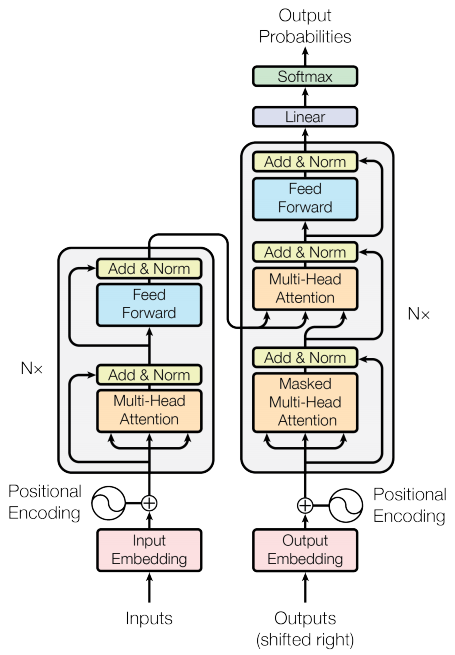

references: https://pytorch.org/tutorials/beginner/translation_transformer.html

## Create Model:

### Data Preprocessing:

In [ ]:
import copy
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List

In [ ]:
DOC_ID = 'doc_id'
SEG_ID = 'seg_id'

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, old_dataset):
        self.old_dataset = old_dataset
        self.doc_id_to_offset = {}
        for data in self.old_dataset:
            doc_id = data[DOC_ID]
            seg_id = data[SEG_ID]
            if doc_id not in self.doc_id_to_offset:
                self.doc_id_to_offset[doc_id] = seg_id
            elif seg_id < self.doc_id_to_offset[doc_id]:
                # current seg id is smaller than previous registered offset
                self.doc_id_to_offset[doc_id] = seg_id

    def __len__(self):
        return len(self.old_dataset)

    def __getitem__(self, idx):
        sample = self.old_dataset[idx]
        doc_id = sample[DOC_ID]

        seg_id = sample[SEG_ID]
        offset = self.doc_id_to_offset[doc_id]
        sample_idx = seg_id - offset
        if sample_idx == 0:
          sample_idx = 1
        sample['idx'] = sample_idx

        return sample

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split dataset
train, test, validation = TranslationDataset(zh_en_dataset['train']), TranslationDataset(zh_en_dataset['test']), TranslationDataset(zh_en_dataset['validation'])

# FOR LOCAL USAGE
LOCAL_TRAIN_DATA_SIZE = 8
subset_indices = []
for i in range(LOCAL_TRAIN_DATA_SIZE):
    subset_indices.append(i)
train_local = Subset(train, subset_indices)

SRC_LANGUAGE = 'zh'
TGT_LANGUAGE = 'en'

In [ ]:
print(len(train))

### Tokenization

In [ ]:
# Place-holders
token_transform = {}
vocab_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='zh_core_web_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

# helper function to yield list of tokens
def yield_tokens(data_iter, language):
  for data_sample in data_iter:
    yield token_transform[language](data_sample['translation'][language])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator
  train_iter = train
  # Create torchtext's Vocab object
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln), min_freq=1, specials=special_symbols, special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

### Build Context

In [ ]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
  def func(txt_input):
      for transform in transforms:
          txt_input = transform(txt_input)
      return txt_input
  return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
  return torch.cat((torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                        vocab_transform[ln], #Numericalization
                        tensor_transform) # Add BOS/EOS and create tensor

In [ ]:
# {'1': ['sentence 1', 'sentence 2']}
context = {}

datasets = [train, test, validation]
for dataset in datasets:
    current_tensors = []
    current_doc_id = dataset[0][DOC_ID]

    for idx, data in enumerate(dataset):
        if data[DOC_ID] != current_doc_id:
            # save
            context[current_doc_id] = current_tensors

            # reset
            current_doc_id = data[DOC_ID]
            current_tensors = []
        current_tensors.append(text_transform[SRC_LANGUAGE](data['translation'][SRC_LANGUAGE]))

    # save the last list of tensors
    context[current_doc_id] = current_tensors

### Seq2Seq Transformer

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
  def __init__(self,
        emb_size: int,
        dropout: float,
        maxlen: int = 5000):
    super(PositionalEncoding, self).__init__()
    den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    pos_embedding = torch.zeros((maxlen, emb_size))
    pos_embedding[:, 0::2] = torch.sin(pos * den)
    pos_embedding[:, 1::2] = torch.cos(pos * den)
    pos_embedding = pos_embedding.unsqueeze(-2)

    self.dropout = nn.Dropout(dropout)
    self.register_buffer('pos_embedding', pos_embedding)

  def forward(self, token_embedding: Tensor):
    return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
  def __init__(self, vocab_size: int, emb_size):
    super(TokenEmbedding, self).__init__()
    self.embedding = nn.Embedding(vocab_size, emb_size)
    self.emb_size = emb_size

  def forward(self, tokens: Tensor):
    res = self.embedding(tokens.long()) * math.sqrt(self.emb_size)
    return res

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
  def __init__(self,
         num_encoder_layers: int,
         num_decoder_layers: int,
         emb_size: int,
         nhead: int,
         src_vocab_size: int,
         tgt_vocab_size: int,
         dim_feedforward: int = 512,
         dim_contextgating: int = 512,
         dropout: float = 0.1):
    super(Seq2SeqTransformer, self).__init__()
    self.transformer = Transformer(d_model=emb_size,
                    nhead=nhead,
                    num_encoder_layers=num_encoder_layers,
                    num_decoder_layers=num_decoder_layers,
                    dim_feedforward=dim_feedforward,
                    dim_contextgating=dim_contextgating,
                    dropout=dropout)
    self.generator = nn.Linear(emb_size, tgt_vocab_size)
    self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
    self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
    self.ctx_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
    self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

  def forward(self,
        src: Tensor,
        trg: Tensor,
        ctx_input: Tensor,
        src_mask: Tensor,
        tgt_mask: Tensor,
        src_padding_mask: Tensor,
        tgt_padding_mask: Tensor,
        memory_key_padding_mask: Tensor,
        ctx_key_padding_mask: Tensor):
    src_emb = self.positional_encoding(self.src_tok_emb(src))
    tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
    ctx_emb = self.positional_encoding(self.ctx_tok_emb(ctx_input))
    outs = self.transformer(src_emb, tgt_emb, ctx_emb, src_mask, tgt_mask, None, src_padding_mask, tgt_padding_mask, memory_key_padding_mask, ctx_key_padding_mask)
    return self.generator(outs)

  def encode(self, src: Tensor, ctx_encoding: Tensor, src_mask: Tensor):
    src_emb = self.positional_encoding(self.src_tok_emb(src))
    return self.transformer.encoder(src_emb, ctx_encoding, src_mask)

  def decode(self, tgt: Tensor, memory: Tensor, ctx_encoding: Tensor, tgt_mask: Tensor):
    tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
    return self.transformer.decoder(tgt_emb, memory, ctx_encoding, tgt_mask)

  def encode_ctx(self, ctx_input: Tensor):
    ctx_emb = self.positional_encoding(self.ctx_tok_emb(ctx_input))
    return self.transformer.context_encoder(ctx_emb)

### Masking
Prevent model from looking into the future words when making predictions

In [ ]:
def generate_square_subsequent_mask(sz):
  mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
  mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
  return mask


def create_mask(src, tgt, ctx_input):
  src_seq_len = src.shape[0]
  tgt_seq_len = tgt.shape[0]

  tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
  src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

  src_padding_mask = (src == PAD_IDX).transpose(0, 1)
  tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
  ctx_padding_mask = (ctx_input == PAD_IDX).transpose(0, 1)
  return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, ctx_padding_mask

### Hyperparameters:

In [ ]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 128
NHEAD = 4
FFN_HID_DIM = 512
CG_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DROPOUT = 0.1
CONTEXT_WINDOW_SIZE = 10

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM, CG_HID_DIM, DROPOUT)

In [ ]:
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

### Batch Processing

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
  src_batch, tgt_batch, ctx_input_batch = [], [], []
  for element in batch:
    idx = element['idx']
    doc_id = element[DOC_ID]

    src_batch.append(context[doc_id][idx])

    tgt_sample = element['translation'][TGT_LANGUAGE]
    tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    if idx == 0:
        d_src = src_batch[0].size()
        ctx_input_batch.append(torch.ones(d_src, dtype=src_batch[0].dtype))
    else:
        startIdx = 0
        if idx > CONTEXT_WINDOW_SIZE:
            startIdx = idx - CONTEXT_WINDOW_SIZE
        ctx_input_batch.append(torch.cat(context[doc_id][startIdx:idx]))

  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
  tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
  ctx_input_batch = pad_sequence(ctx_input_batch, padding_value=PAD_IDX)
  return src_batch, tgt_batch, ctx_input_batch

## Train Model

In [ ]:
from torch.utils.data import DataLoader
from torchtext.data.metrics import bleu_score
import torch

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = train
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt, ctx_input in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        ctx_input = ctx_input.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, ctx_padding_mask = create_mask(src, tgt_input, ctx_input)

        logits = model(src, tgt_input, ctx_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask, ctx_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0
    # total_bleu = 0
    total_tokens = 0
    count = 0

    val_iter = validation
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt, ctx_input in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)
        ctx_input = ctx_input.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, ctx_padding_mask = create_mask(src, tgt_input, ctx_input)

        logits = model(src, tgt_input, ctx_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask, ctx_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

        not_special_tokens = lambda x: x!="<bos>" and x!="<eos>" and x!="<pad>"

#         # Calculate BLEU score
#         translations = []
#         targets = []
#         for i in range(logits.shape[1]):
#             predicted_ids = logits[:, i, :].argmax(1)
#             # translations.append(predicted_ids.cpu().numpy())
#             translations.append(list(filter(not_special_tokens, vocab_transform[TGT_LANGUAGE].lookup_tokens(list(predicted_ids.cpu().numpy())))))
#             # targets.append([tgt_out[:, i].cpu().numpy()])
#             targets.append([list(filter(not_special_tokens, vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_out[:, i].cpu().numpy()))))])
#         print(translations[0])
#         print(targets[0])

#         total_bleu += bleu_score(translations, targets)

        # Calculate perplexity
        non_pad_tokens = tgt_out.ne(PAD_IDX).sum().item()
        total_tokens += non_pad_tokens
        count += 1

    avg_loss = losses / len(val_dataloader)
    # avg_bleu = total_bleu / count if count > 0 else 0
    perplexity = torch.exp(torch.tensor(losses / total_tokens))

    return avg_loss, perplexity.item()

In [ ]:
train_losses = []
val_losses = []
# val_bleu_scores = []
val_perplexity_scores = []

In [ ]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS+1):
  start_time = timer()
  train_loss = train_epoch(transformer, optimizer)
  end_time = timer()
  val_loss, val_perplexity = evaluate(transformer)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  # val_bleu_scores.append(val_bleu)
  val_perplexity_scores.append(val_perplexity)
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Val perplexity: {val_perplexity:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

In [ ]:
epochs = range(1, NUM_EPOCHS + 1)
hyperparameters = '256/4/512/64/4/4/0.2'

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('LOSS, ' + hyperparameters)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_perplexity_scores, 'b', label='Validation Perplexity')
plt.title('Perplexity, ' + hyperparameters)
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

In [ ]:
print(val_perplexity_scores)

In [ ]:
import time
torch.save(transformer.state_dict(), './transformer_model_svt')

## Test and Evaluate

### Load Model

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#model_path = '/content/drive/MyDrive/cs4248_team51/models/transformer_model_svt'
model_path = './transformer_model_svt'

In [ ]:
# Import model
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE, NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
transformer.load_state_dict(torch.load(model_path))
transformer.eval()
transformer.to(DEVICE)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
  def func(txt_input):
      for transform in transforms:
          txt_input = transform(txt_input)
      return txt_input
  return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
  return torch.cat((torch.tensor([BOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                        vocab_transform[ln], #Numericalization
                        tensor_transform) # Add BOS/EOS and create tensor

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, ctx_input, src_mask, max_len, start_symbol):
  src = src.to(DEVICE)
  src_mask = src_mask.to(DEVICE)

  ctx_input = ctx_input.to(DEVICE)
  ctx_encoding = model.encode_ctx(ctx_input)

  memory = model.encode(src, ctx_encoding, src_mask)
  ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
  for i in range(max_len-1):
      memory = memory.to(DEVICE)
      tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                  .type(torch.bool)).to(DEVICE)
      out = model.decode(ys, memory, ctx_encoding, tgt_mask)
      out = out.transpose(0, 1)
      prob = model.generator(out[:, -1])
      _, next_word = torch.max(prob, dim=1)
      next_word = next_word.item()

      ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
      if next_word == EOS_IDX:
        break
  return ys

# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str, ctx_input: List[str]):
  if len(ctx_input) == 0:
    raise RuntimeError('ctx_input must be non-empty')

  model.eval()
  src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
  num_tokens = src.shape[0]
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

  ctx_tensors = []
  for ctx_sentence in ctx_input:
    ctx_tensor = text_transform[SRC_LANGUAGE](ctx_sentence).view(-1, 1)
    ctx_tensors.append(ctx_tensor)
  ctx_input = torch.cat(ctx_tensors)

  tgt_tokens = greedy_decode(model, src, ctx_input, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
  return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [ ]:
# San check

print(translate(transformer, "你好吗?", ["我不好。"]))
print(translate(transformer, "我仍然非常热衷于这项运动", ["自己也因为缺少竞争对手而对赛车有些厌倦"]))

### Metrics Functions

In [ ]:
import json

contains_proper_noun_sentences_file = open('contains_proper_noun_sentences.json')
contains_proper_noun_sentences = json.load(contains_proper_noun_sentences_file)

contains_idiom_sentences_file = open('contains_idiom_sentences.json')
contains_idiom_sentences = json.load(contains_idiom_sentences_file)

contains_polyphones_sentences_file = open('contains_polyphones_sentences.json')
contains_polyphones_sentences = json.load(contains_polyphones_sentences_file)

contains_unseen_words_sentences_file = open('contains_unseen_words_sentences.json')
contains_unseen_words_sentences = json.load(contains_unseen_words_sentences_file)

contains_missing_pronouns_sentences_file = open('contains_missing_pronouns_sentences.json')
contains_missing_pronouns_sentences = json.load(contains_missing_pronouns_sentences_file)

contains_unmatched_pronouns_sentences_file = open('contains_unmatched_pronouns_sentences.json')
contains_unmatched_pronouns_sentences = json.load(contains_unmatched_pronouns_sentences_file)

simple_sentences_file = open('simple_sentences.json')
simple_sentences = json.load(simple_sentences_file)

In [ ]:
## Bert

def calc_bert_score(references, candidates):
        
    P, R, F1 = score(candidates, references, lang='en', verbose=True)


    plt.hist(F1, bins=20)
    plt.xlabel("score")
    plt.ylabel("counts")
    plt.show()

    return R.mean(), P.mean(), F1.mean()

In [ ]:
# bleu score

def calc_bleu(references, candidates):
    candidate_tokens_arr = []
    for candidate in candidates:
        candidate_tokens_arr.append(token_transform[TGT_LANGUAGE](candidate))
    reference_tokens_arr = []
    for reference in references:
        reference_tokens_arr.append([token_transform[TGT_LANGUAGE](reference)])
    b_score = corpus_bleu(reference_tokens_arr, candidate_tokens_arr)
    return b_score


In [ ]:
# rouge score

from rouge_score import rouge_scorer

def calc_rouge(references, candidates):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    total_rouge1 = {'precision': 0, 'recall': 0, 'fmeasure': 0}
    total_rouge2 = {'precision': 0, 'recall': 0, 'fmeasure': 0}
    total_rouge3 = {'precision': 0, 'recall': 0, 'fmeasure': 0}
    total_rouge4 = {'precision': 0, 'recall': 0, 'fmeasure': 0}
    total_rougeL = {'precision': 0, 'recall': 0, 'fmeasure': 0}
    num_samples = len(references)
    for i in range(0, num_samples):
        sample = scorer.score(references[i], candidates[i])

        total_rougeL['precision'] += sample['rougeL'].precision
        total_rougeL['recall'] += sample['rougeL'].recall
        total_rougeL['fmeasure'] += sample['rougeL'].fmeasure

    # Calculate averages by dividing each sum by the number of samples

    average_rougeL = {
        'precision': total_rougeL['precision'] / num_samples,
        'recall': total_rougeL['recall'] / num_samples,
        'fmeasure': total_rougeL['fmeasure'] / num_samples,
    }

    # Print or use the averages as needed
    return average_rougeL

### Inference

In [ ]:
# Create test context
test_context = {}
current_sentences = []
current_doc_id = test[0][DOC_ID]

for idx, data in enumerate(test):
  if data[DOC_ID] != current_doc_id:
    # save
    test_context[current_doc_id] = current_sentences

    # reset
    current_doc_id = data[DOC_ID]
    current_sentences = []
  current_sentences.append(data['translation'][SRC_LANGUAGE])

# save the last list of tensors
test_context[current_doc_id] = current_sentences

In [ ]:
references = []
candidates = []
candidate_set = {}

i = 0
for m in test:
    src_sentence = m['translation'][SRC_LANGUAGE]
    tgt_sentence = m['translation'][TGT_LANGUAGE]
    doc_id = m['doc_id']
    idx = m['idx']
    ctx_sentences = test_context[doc_id]
    startIdx = 0
    if idx > CONTEXT_WINDOW_SIZE:
        startIdx = idx - CONTEXT_WINDOW_SIZE
    ctx_sentences = test_context[doc_id][startIdx:idx]

    reference_tokens = token_transform[TGT_LANGUAGE](tgt_sentence)
    references.append(' '.join(reference_tokens))
    candidate = translate(transformer, src_sentence, ctx_sentences)
    candidates.append(candidate)
    candidate_set[(doc_id, idx)] = candidate

print(calc_bert_score(references, candidates))
print(calc_bleu(references, candidates))
print(calc_rouge(references, candidates))

In [ ]:
# contains_proper_noun_sentences

references = []
candidates = []
for m in contains_proper_noun_sentences:
    reference_tokens = token_transform[TGT_LANGUAGE](m[TGT_LANGUAGE])
    references.append(' '.join(reference_tokens))
    candidate = candidate_set[(m[DOC_ID], m['idx'])]
    if candidate == None or candidate == '':
        raise RuntimeError((m[DOC_ID], m['idx']))
    candidates.append(candidate_set[(m[DOC_ID], m['idx'])])
    
print(calc_bert_score(references, candidates))
print(calc_bleu(references, candidates))
print(calc_rouge(references, candidates))

In [ ]:
# contains_idiom_sentences

references = []
candidates = []
for m in contains_idiom_sentences:
    reference_tokens = token_transform[TGT_LANGUAGE](m[TGT_LANGUAGE])
    references.append(' '.join(reference_tokens))
    candidate = candidate_set[(m[DOC_ID], m['idx'])]
    if candidate == None or candidate == '':
        raise RuntimeError((m[DOC_ID], m['idx']))
    candidates.append(candidate_set[(m[DOC_ID], m['idx'])])

    
print(calc_bert_score(references, candidates))
print(calc_bleu(references, candidates))
print(calc_rouge(references, candidates))

In [ ]:
# contains_polyphones_sentences

references = []
candidates = []
for m in contains_polyphones_sentences:
    reference_tokens = token_transform[TGT_LANGUAGE](m[TGT_LANGUAGE])
    references.append(' '.join(reference_tokens))
    candidate = candidate_set[(m[DOC_ID], m['idx'])]
    if candidate == None or candidate == '':
        raise RuntimeError((m[DOC_ID], m['idx']))
    candidates.append(candidate_set[(m[DOC_ID], m['idx'])])

    
print(calc_bert_score(references, candidates))
print(calc_bleu(references, candidates))
print(calc_rouge(references, candidates))

In [ ]:
# contains_unseen_words_sentences

references = []
candidates = []
for m in contains_unseen_words_sentences:
    reference_tokens = token_transform[TGT_LANGUAGE](m[TGT_LANGUAGE])
    references.append(' '.join(reference_tokens))
    candidate = candidate_set[(m[DOC_ID], m['idx'])]
    if candidate == None or candidate == '':
        raise RuntimeError((m[DOC_ID], m['idx']))
    candidates.append(candidate_set[(m[DOC_ID], m['idx'])])

    
print(calc_bert_score(references, candidates))
print(calc_bleu(references, candidates))
print(calc_rouge(references, candidates))

In [ ]:
# contains_missing_pronouns_sentences

references = []
candidates = []
for m in contains_missing_pronouns_sentences:
    reference_tokens = token_transform[TGT_LANGUAGE](m[TGT_LANGUAGE])
    references.append(' '.join(reference_tokens))
    candidate = candidate_set[(m[DOC_ID], m['idx'])]
    if candidate == None or candidate == '':
        raise RuntimeError((m[DOC_ID], m['idx']))
    candidates.append(candidate_set[(m[DOC_ID], m['idx'])])

    
print(calc_bert_score(references, candidates))
print(calc_bleu(references, candidates))
print(calc_rouge(references, candidates))

In [ ]:
# contains_unmatched_pronouns_sentences

references = []
candidates = []
for m in contains_unmatched_pronouns_sentences:
    reference_tokens = token_transform[TGT_LANGUAGE](m[TGT_LANGUAGE])
    references.append(' '.join(reference_tokens))
    candidate = candidate_set[(m[DOC_ID], m['idx'])]
    if candidate == None or candidate == '':
        raise RuntimeError((m[DOC_ID], m['idx']))
    candidates.append(candidate_set[(m[DOC_ID], m['idx'])])

    
print(calc_bert_score(references, candidates))
print(calc_bleu(references, candidates))
print(calc_rouge(references, candidates))

In [ ]:
# simple_sentences

references = []
candidates = []
for m in simple_sentences:
    reference_tokens = token_transform[TGT_LANGUAGE](m[TGT_LANGUAGE])
    references.append(' '.join(reference_tokens))
    candidate = candidate_set[(m[DOC_ID], m['idx'])]
    if candidate == None or candidate == '':
        raise RuntimeError((m[DOC_ID], m['idx']))
    candidates.append(candidate_set[(m[DOC_ID], m['idx'])])

    
print(calc_bert_score(references, candidates))
print(calc_bleu(references, candidates))
print(calc_rouge(references, candidates))